Повторим шаги из exd1.ipynb, но с ипользованием датасета News_Category_Dataset_v3 с сайта Kaggle.com

1) Подготовка данных

In [2]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics

# Загрузка пользовательского датасета
with open("News_Category_Dataset_v3.json", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# Фильтрация только нужных столбцов
df = df[["category", "short_description"]]
df = df[df["short_description"].str.strip() != ""]  # удалим пустые описания

# Для примера ограничим количество категорий
top_categories = df["category"].value_counts().nlargest(5).index.tolist()
df = df[df["category"].isin(top_categories)]

texts = df["short_description"].tolist()
labels, label_names = pd.factorize(df["category"])
true_k = len(label_names)
unique_labels, category_sizes = np.unique(labels, return_counts=True)

print(f"{len(texts)} документов - {true_k} категории")

84381 документов - 5 категории


Создаём функцию fit_and_evaluate, которая обучает модель кластеризации несколько раз с разными random_state и вычисляет метрики

In [3]:
evaluations = []
evaluations_std = []

def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(labels, km.labels_))
        scores["Silhouette Coefficient"].append(metrics.silhouette_score(X, km.labels_, sample_size=2000))

    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {"estimator": name, "train_time": train_times.mean()}
    evaluation_std = {"estimator": name, "train_time": train_times.std()}
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

Преобразуем текстовые данные в векторное представление

In [4]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words="english")

t0 = time()
X_tfidf = vectorizer.fit_transform(texts)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

vectorization done in 0.745 s
n_samples: 84381, n_features: 17006
0.001


Применяем KMeans для кластеризации текстов на основе TF-IDF векторов

In [5]:
for seed in range(5):
    kmeans = KMeans(n_clusters=true_k, max_iter=100, n_init=1, random_state=seed).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Количество документов в каждом кластере: {cluster_sizes}")
print(f"Настоящее распределение по категориям: {category_sizes}")

# Повтор с лучшим результатом по инерции
kmeans = KMeans(n_clusters=true_k, max_iter=100, n_init=5)
fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

Количество документов в каждом кластере: [ 3116  3626   961  2587 74091]
Количество документов в каждом кластере: [   22 81624  1261  1170   304]
Количество документов в каждом кластере: [ 3497 73711   961  1948  4264]
Количество документов в каждом кластере: [ 3385   961 67675  6706  5654]
Количество документов в каждом кластере: [  961  3537 73170  2227  4486]
Настоящее распределение по категориям: [14774 32441 17943  9802  9421]
clustering done in 0.38 ± 0.02 s 
Homogeneity: 0.036 ± 0.018
Completeness: 0.086 ± 0.036
V-measure: 0.051 ± 0.024
Adjusted Rand-Index: 0.002 ± 0.016
Silhouette Coefficient: 0.004 ± 0.001


Применяем LSA

In [6]:
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance: {explained_variance * 100:.1f}%")

# Повтор кластеризации на пониженной размерности
kmeans = KMeans(n_clusters=true_k, max_iter=100, n_init=1)
fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

minibatch_kmeans = MiniBatchKMeans(n_clusters=true_k, n_init=1, init_size=1000, batch_size=1000)
fit_and_evaluate(minibatch_kmeans, X_lsa, name="MiniBatchKMeans\nwith LSA on tf-idf vectors")

LSA done in 1.497 s
Explained variance: 11.1%
clustering done in 0.15 ± 0.05 s 
Homogeneity: 0.050 ± 0.028
Completeness: 0.068 ± 0.027
V-measure: 0.057 ± 0.029
Adjusted Rand-Index: 0.001 ± 0.010
Silhouette Coefficient: 0.027 ± 0.009
clustering done in 0.24 ± 0.03 s 
Homogeneity: 0.096 ± 0.015
Completeness: 0.112 ± 0.019
V-measure: 0.104 ± 0.016
Adjusted Rand-Index: 0.041 ± 0.026
Silhouette Coefficient: 0.029 ± 0.002


Определяем, какие слова лучше всего характеризуют каждый кластер

In [7]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Кластер {i}:", end=" ")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]}", end=" ")
    print()

Кластер 0: new time just like year life day world don ve 
Кластер 1: people health help study national government americans public cancer sleep 
Кластер 2: film video red night movie season summer singer home actor 
Кластер 3: said president obama elect vice house people senator new secretary 
Кластер 4: trump donald president administration campaign said house clinton republican election 


Вместо TfidfVectorizer используем HashingVectorizer + TfidfTransformer + LSA

In [8]:
lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(texts)
print(f"vectorization done in {time() - t0:.3f} s")

fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")
fit_and_evaluate(minibatch_kmeans, X_hashed_lsa, name="MiniBatchKMeans\nwith LSA on hashed vectors")

vectorization done in 2.805 s
clustering done in 0.14 ± 0.02 s 
Homogeneity: 0.075 ± 0.044
Completeness: 0.090 ± 0.041
V-measure: 0.081 ± 0.043
Adjusted Rand-Index: 0.019 ± 0.022
Silhouette Coefficient: 0.029 ± 0.004
clustering done in 0.25 ± 0.03 s 
Homogeneity: 0.086 ± 0.024
Completeness: 0.102 ± 0.024
V-measure: 0.093 ± 0.024
Adjusted Rand-Index: 0.036 ± 0.016
Silhouette Coefficient: 0.028 ± 0.004


Строим таблицу и визуализацию с результатами кластеризации

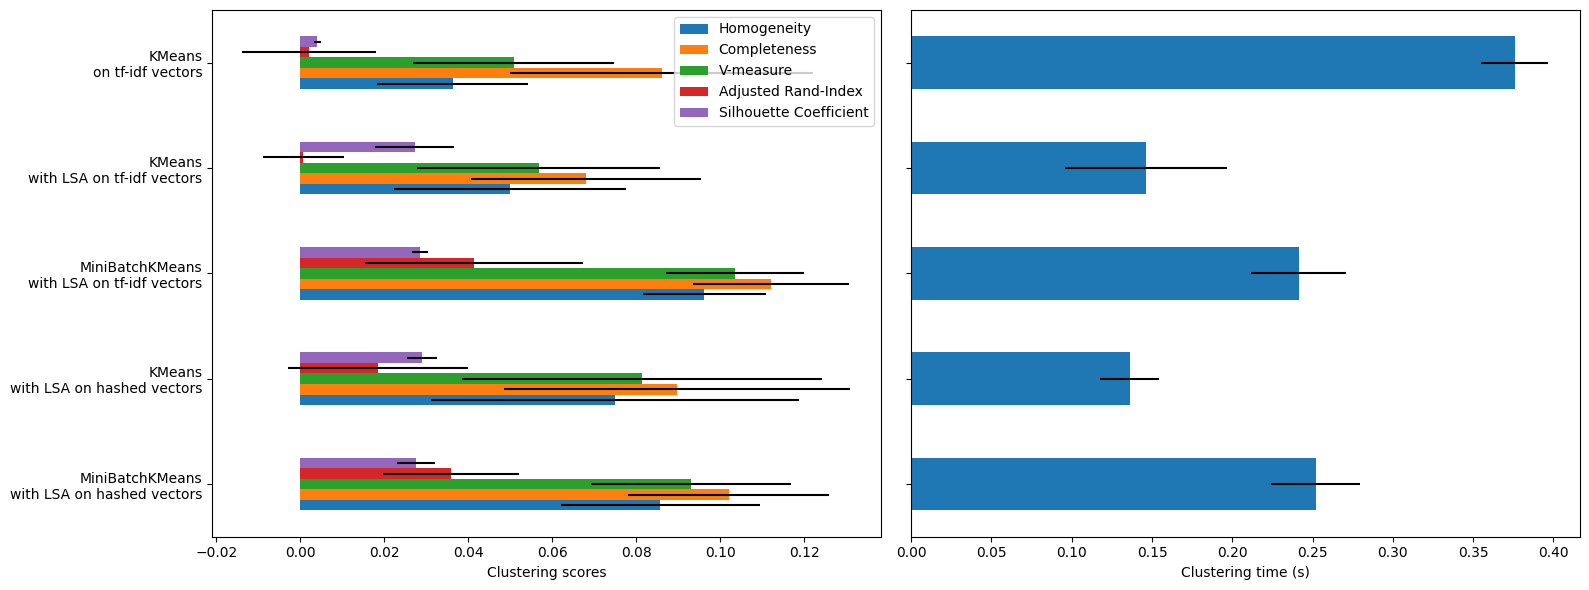

In [9]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(["train_time"], axis="columns").plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()
plt.show()

Модель успешно справилась с заданием, используя скачанный мной датасет, наиболее эффективным вновь оказался K-means с использованием LSA на хэшированных векторах, но стоит отметить что время кластеризации выросло, ввиду того что количество информации внутри скачанного датасета больше, чем в втроенном датасете fetch_20newsgroups